## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [60]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from sklearn.metrics import accuracy_score


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  

In [61]:
print(torch.cuda.is_available())

True


In [62]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [63]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [64]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [65]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [66]:
len(fmnist_dataset_test)

10000

In [67]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [68]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            
            #Input layer 
            nn.Linear(input_shape, 397 ), # Using the mean of the number of neurons in the input layer and output layer as the number of neurons in the hidden layer 
            nn.BatchNorm1d(397),          #Using batch normalization before the non-linear activation function
            nn.ReLU(),
            nn.Dropout(p = 0.3),          #Increasing regularization by adding dropout for decrease overfitting

            #Hidden layer 
            #out_features = ((input_shape + num_classes) // 2 + num_classes ) // 2 = (397 + 10) // 2 = 203 , #Take the mean again 
            nn.Linear(397, 203 ),
            nn.BatchNorm1d(203),          #Using batch normalization before the non-linear activation function
            nn.ReLU(), 
            nn.Dropout(p = 0.3),          #Increasing regularization by adding dropout for decrease overfitting

            #Output layer  
            nn.Linear(203, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [69]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 397]         311,645
       BatchNorm1d-3                  [-1, 397]             794
              ReLU-4                  [-1, 397]               0
           Dropout-5                  [-1, 397]               0
            Linear-6                  [-1, 203]          80,794
       BatchNorm1d-7                  [-1, 203]             406
              ReLU-8                  [-1, 203]               0
           Dropout-9                  [-1, 203]               0
           Linear-10                   [-1, 10]           2,040
Total params: 395,679
Trainable params: 395,679
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.51
Estimated T

Your experiments come here:

In [70]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss() #****No need to add extra softmax or logsofmax layer at the end of the network since torch applies softmax() to the input when is called loss_func(predictions, Y_batch) torch does loss_func(softmax(predictions), Y_batch)

# Your experiments, training and validation loops here

In [71]:
#Looping params 
n_epoch = 30 # 3 * out_features  
batch_size = 128 #It was already defined in train_loader, Is usually a good practice to choose a power of 2

In [72]:
#Training loop 
train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []

for epoch in range(n_epoch):
    model.train(True) #model.train() is used to "tell the model that is being trained", some modules, such as BatchNorm() are designed to behave differently during training and evaluation
    
    current_train_loss = [] 
    current_train_accuracy = [] 

    current_test_loss = []
    current_test_accuracy = [] 

    for X_batch, Y_batch in train_loader: 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device) 

        #Initializing the optimizer 
        opt.zero_grad() #"This is to reset the gradient() value to zero to prevent any existing value from affecting the newly calculated value. Usually you need to do this for every epoch of the training process."

        #Forward 
        predictions = model.forward(X_batch)
        loss = loss_func(predictions, Y_batch.long())

        #Backward 
        loss.backward() #Calculating the gradient value for all network parameters, that is, for each weight and bias of each neuron in the network 

        #Updating the weights and bias using the gradient values calculated in the previous step 
        opt.step()

        #Keeping track of the TRAINING loss values and accuracy scores PER ITERATION for calculating TRAINING the loss and accuracy of the current epoch 
        current_train_loss.append(loss.detach().cpu().numpy()) #loss.detach().cpu().numpy() to prevent error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
        current_train_accuracy.append(accuracy_score(np.argmax(predictions.detach().cpu().numpy(), axis=1), Y_batch.detach().cpu().numpy() ) )

    #Keeping track of the TRAINING loss values and accuracy scores PER EPOCH for plotting 
    train_loss_history.append(np.mean(current_train_loss) )
    train_accuracy_history.append(np.mean(current_train_accuracy) )

    #***********Computing accuracy for the model trained at the current epoch  
    model.train(False)    #This has effect on some modules that on torch behave differently, based won the value of train(), BatchNorm is one of them
    with torch.no_grad(): # "Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True. In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True."
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            #Making a prediction
            predictions = model.forward(X_batch)

            #Keeping track of the TESTING loss values and accuracy scores PER ITERATION for calculating the TESTING loss and accuracy of the current epoch 
            current_test_loss.append(loss_func(predictions, Y_batch.long()).detach().cpu().numpy() ) #loss.detach().cpu().numpy() to prevent error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
            current_test_accuracy.append(accuracy_score(np.argmax(predictions.detach().cpu().numpy(), axis=1), Y_batch.detach().cpu().numpy() ) )

            #No backward() or step() is needed since is only testing

    #Keeping track of the TESTING loss values and accuracy scores PER EPOCH for plotting 
    test_loss_history.append(np.mean(current_test_loss) ) 
    test_accuracy_history.append(np.mean(current_test_accuracy ) )


C:\Users\gablj\AppData\Local\Temp\ipykernel_56112\1021044083.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(test_loss_history, 'b', color = 'orange' , label = "Test loss")


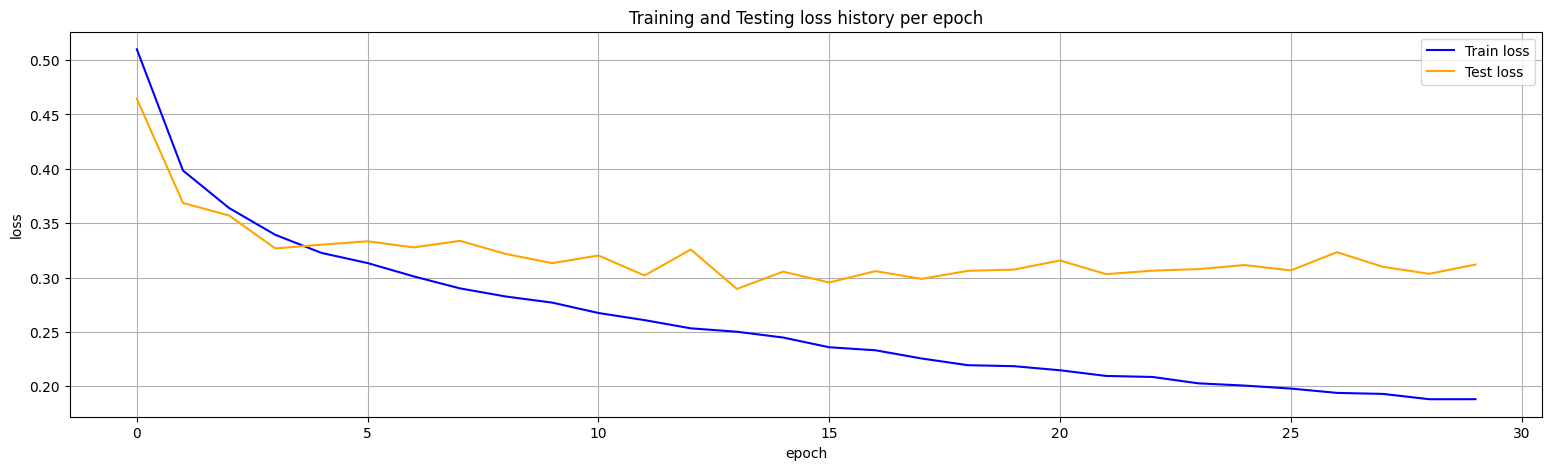

Current Training loss value for the model is = 0.18819420039653778
Current Testing loss value for the model is = 0.31198543310165405
Difference between Current Training and Current Testing loss values for the model is = 0.12379123270511627


In [73]:
#Plotting loss history 

plt.figure(figsize=(19, 5))
plt.title("Training and Testing loss history per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_history, 'b', label = "Train loss") 
plt.plot(test_loss_history, 'b', color = 'orange' , label = "Test loss") 
plt.legend(loc = 'best')
plt.grid()

plt.show() 

print(f"Current Training loss value for the model is = {train_loss_history[-1]}")
print(f"Current Testing loss value for the model is = {test_loss_history[-1]}")
print(f"Difference between Current Training and Current Testing loss values for the model is = {test_loss_history[-1] - train_loss_history[-1]}")

C:\Users\gablj\AppData\Local\Temp\ipykernel_56112\4072280129.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(test_accuracy_history, 'b', color = 'orange' , label = "Test accuracy" )


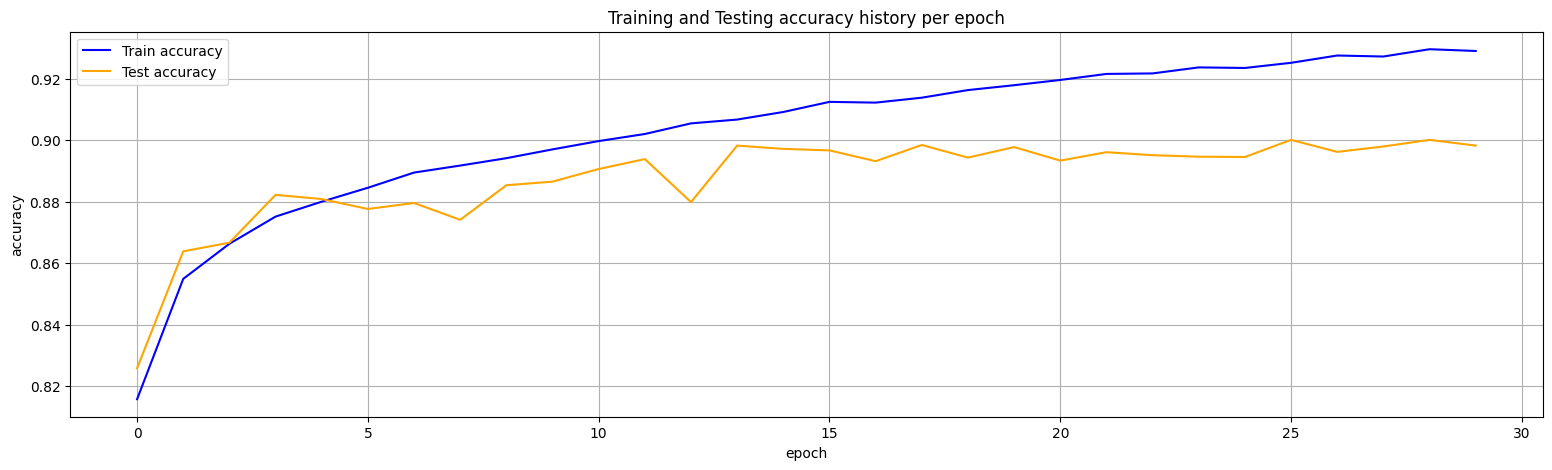

Current Training accuracy score for the model is = 0.9289823205401563
Current Testing accuracy score for the model is = 0.8982421875
Difference between Current Training and Current Testing accuracy score values for the model is = -0.030740133040156326


In [74]:
#Plotting accuracy history 

plt.figure(figsize=(19, 5))
plt.title("Training and Testing accuracy history per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy_history, 'b', label = "Train accuracy") 
plt.plot(test_accuracy_history, 'b', color = 'orange' , label = "Test accuracy" ) 
plt.legend(loc = 'best')
plt.grid()

plt.show() 

print(f"Current Training accuracy score for the model is = {train_accuracy_history[-1]}")
print(f"Current Testing accuracy score for the model is = {test_accuracy_history[-1]}")
print(f"Difference between Current Training and Current Testing accuracy score values for the model is = {test_accuracy_history[-1] - train_accuracy_history[-1]}")

In [75]:
def accuracy(model, test_set):
    avg_accuracy = []
    for X_batch, Y_batch in test_set: 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        pred = model.forward(X_batch).detach().cpu().numpy()
        #pred = model.forward(X_batch).softmax(dim=1).detach().cpu().numpy() #Does it make any difference to apply softmax() at this step?, softmax(dim=1) is applied to "normalize" the output vector values between 0 and 1 with sum = 1, t.e., so that they would take a probability form
        proba = np.argmax(pred, axis=1)    #Since the index with the maximum value corresponds to the label with the maximum probability 
        avg_accuracy.append(accuracy_score(Y_batch.detach().cpu().numpy(), proba))
    return np.mean(avg_accuracy)

print(f"The model testing accuracy is = {accuracy(model, test_loader)}") 

The model testing accuracy is = 0.8982421875


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [76]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
           
            #Input layer 
            nn.Linear(input_shape, 350), 
            nn.ReLU(),

            #Hidden layer 
            nn.Linear(350, 200),
            nn.ReLU(), 

            #Output layer 
            nn.Linear(200, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [77]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 350]         274,750
              ReLU-3                  [-1, 350]               0
            Linear-4                  [-1, 200]          70,200
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 346,960
Trainable params: 346,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.32
Estimated Total Size (MB): 1.34
----------------------------------------------------------------


In [78]:
#*****Changing training set size 
batch_indices = list(range(0, len(fmnist_dataset_train), 5) )
train_subset = torch.utils.data.Subset(fmnist_dataset_train, batch_indices)

train_loader_subset = torch.utils.data.DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 2)

print(len(train_subset), len(train_loader_subset), len(fmnist_dataset_train) , len(train_loader)) #len(train_loader_subset) * batch_size - amount 

12000 94 60000 469


In [79]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [80]:
#Looping params 
n_epoch = 90 # 9 * out_features , a high number of epoch for overfitting 
batch_size = 128 #It was already defined in train_loader, Is usually a good practice to choose a power of 2, in this case 2^5 = 32 was choosen since there are 128 objects in train_loader

#Training loop 
train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []

for epoch in range(n_epoch):
    model.train(True) #model.train() is used to "tell the model that is being trained", some modules, such as BatchNorm() are designed to behave differently during training and evaluation
    
    current_train_loss = [] 
    current_train_accuracy = [] 

    current_test_loss = []
    current_test_accuracy = [] 

    for X_batch, Y_batch in train_loader_subset: #Taking batches from the train subset
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device) 

        #Initializing the optimizer 
        opt.zero_grad() #"This is to reset the gradient() value to zero to prevent any existing value from affecting the newly calculated value. Usually you need to do this for every epoch of the training process."

        #Forward 
        predictions = model.forward(X_batch)
        loss = loss_func(predictions, Y_batch.long())

        #Backward 
        loss.backward() #Calculating the gradient value for all network parameters, that is, for each weight and bias of each neuron in the network 

        #Updating the weights and bias using the gradient values calculated in the previous step 
        opt.step()

        #Keeping track of the TRAINING loss values and accuracy scores PER ITERATION for calculating TRAINING the loss and accuracy of the current epoch 
        current_train_loss.append(loss.detach().cpu().numpy()) #loss.detach().cpu().numpy() to prevent error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
        current_train_accuracy.append(accuracy_score(np.argmax(predictions.detach().cpu().numpy(), axis=1), Y_batch.detach().cpu().numpy() ) )

    #Keeping track of the TRAINING loss values and accuracy scores PER EPOCH for plotting 
    train_loss_history.append(np.mean(current_train_loss) )
    train_accuracy_history.append(np.mean(current_train_accuracy) )

    #***********Computing accuracy for the model trained at the current epoch  
    model.train(False)      #This has effect on some modules that on torch behave differently, based won the value of train(), BatchNorm is one of them
    with torch.no_grad():   # "Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True. In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True."
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            #Making a prediction
            predictions = model.forward(X_batch)

            #Keeping track of the TESTING loss values and accuracy scores PER ITERATION for calculating the TESTING loss and accuracy of the current epoch 
            current_test_loss.append(loss_func(predictions, Y_batch.long()).detach().cpu().numpy() ) #loss.detach().cpu().numpy() to prevent error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
            current_test_accuracy.append(accuracy_score(np.argmax(predictions.detach().cpu().numpy(), axis=1), Y_batch.detach().cpu().numpy() ) )

            #No backward() or step() is needed since is only testing

    #Keeping track of the TESTING loss values and accuracy scores PER EPOCH for plotting 
    test_loss_history.append(np.mean(current_test_loss) ) 
    test_accuracy_history.append(np.mean(current_test_accuracy ) )


C:\Users\gablj\AppData\Local\Temp\ipykernel_56112\1095534604.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(test_loss_history, 'b', color = 'orange' , label = "Test loss")


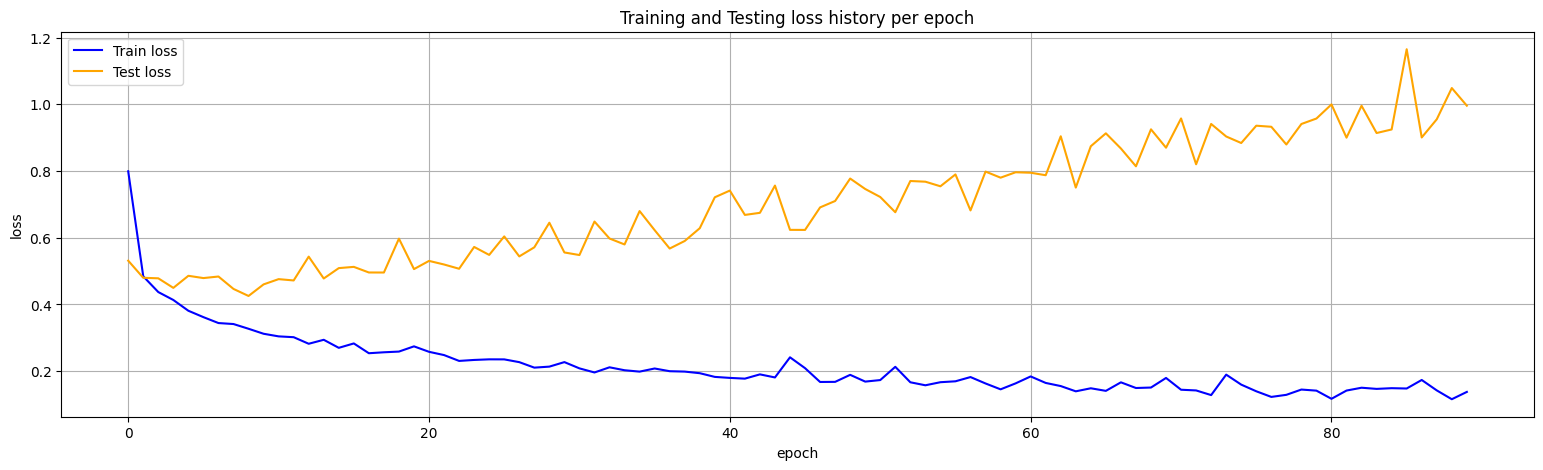

Current Training loss value for the model is = 0.13775500655174255
Current Testing loss value for the model is = 0.9960902333259583
Difference between Current Training and Current Testing loss values for the model is = 0.8583352565765381


In [81]:
#Plotting loss history 

plt.figure(figsize=(19, 5))
plt.title("Training and Testing loss history per epoch")
#plt.xlabel("n-iteration")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_history, 'b', label = "Train loss") 
plt.plot(test_loss_history, 'b', color = 'orange' , label = "Test loss") 
plt.legend(loc = 'best')
plt.grid()
#plt.xticks(range(0, len(loss_history)))

plt.show() 

#****OJO The next message is wrong if the graph was printed PER EPOCH instead of PER ITERATION
#print(f"{len(train_loss_history)} batches were trained each of {len(train_loss_history) // n_epoch} objects during {n_epoch} epochs ")
print(f"Current Training loss value for the model is = {train_loss_history[-1]}")
print(f"Current Testing loss value for the model is = {test_loss_history[-1]}")
print(f"Difference between Current Training and Current Testing loss values for the model is = {test_loss_history[-1] - train_loss_history[-1]}")

C:\Users\gablj\AppData\Local\Temp\ipykernel_56112\1709061117.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(test_accuracy_history, 'b', color = 'orange' , label = "Test accuracy" )


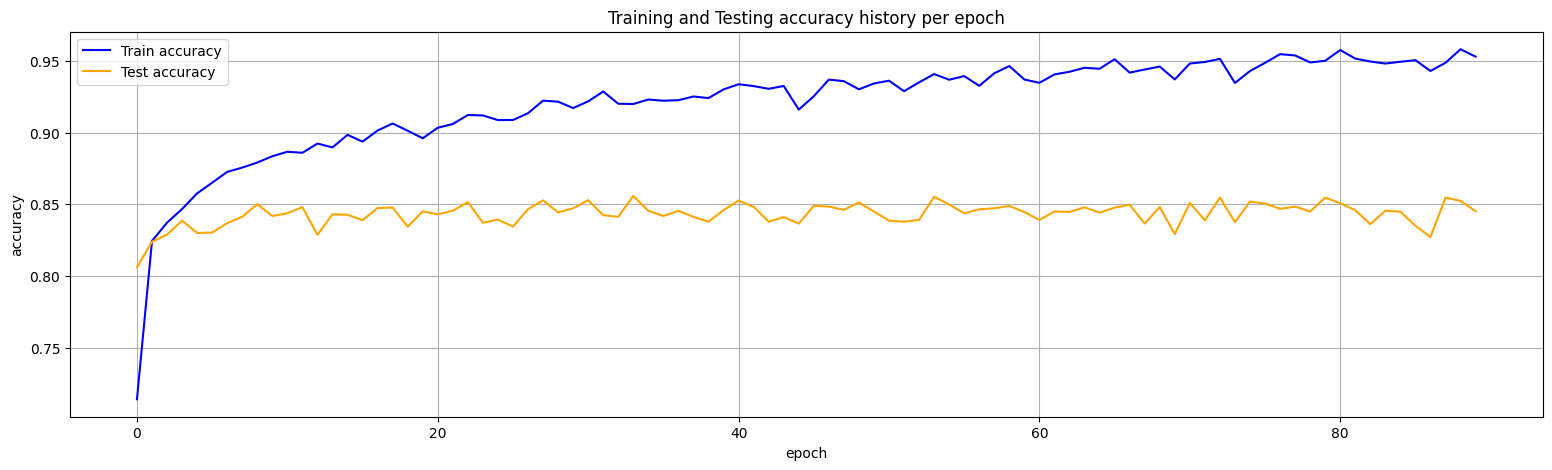

Current Training accuracy score for the model is = 0.9528479609929078
Current Testing accuracy score for the model is = 0.84521484375
Difference between Current Training and Current Testing accuracy score values for the model is = -0.1076331172429078


In [82]:
#Plotting accuracy history 

plt.figure(figsize=(19, 5))
plt.title("Training and Testing accuracy history per epoch")
#plt.xlabel("n-iteration")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy_history, 'b', label = "Train accuracy") 
plt.plot(test_accuracy_history, 'b', color = 'orange' , label = "Test accuracy" ) 
plt.legend(loc = 'best')
plt.grid()
#plt.xticks(range(0, len(loss_history)))

plt.show() 

#****OJO The next message is wrong if the graph was printed PER EPOCH instead of PER ITERATION
#print(f"{len(train_accuracy_history)} batches were trained each of {len(train_accuracy_history) // n_epoch} objects during {n_epoch} epochs ") 
print(f"Current Training accuracy score for the model is = {train_accuracy_history[-1]}")
print(f"Current Testing accuracy score for the model is = {test_accuracy_history[-1]}")
print(f"Difference between Current Training and Current Testing accuracy score values for the model is = {test_accuracy_history[-1] - train_accuracy_history[-1]}")

In [83]:
print(f"The model testing accuracy is = {accuracy(model, test_loader)}")

The model testing accuracy is = 0.84521484375


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [84]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            #Input layer 
            nn.Linear(input_shape, 350), 
            nn.BatchNorm1d(350),          #Using batch normalization before the non-linear activation function
            nn.ReLU(),
            nn.Dropout(p = 0.3),

            #Hidden layer with number of nodes equal to the mean of the number of neurons in the input layer and output layer
            nn.Linear(350, 200),
            nn.BatchNorm1d(200),          #Using batch normalization before the non-linear activation function
            nn.ReLU(),
            nn.Dropout(p = 0.3), 

            #Output layer 
            nn.Linear(200, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [85]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 350]         274,750
       BatchNorm1d-3                  [-1, 350]             700
              ReLU-4                  [-1, 350]               0
           Dropout-5                  [-1, 350]               0
            Linear-6                  [-1, 200]          70,200
       BatchNorm1d-7                  [-1, 200]             400
              ReLU-8                  [-1, 200]               0
           Dropout-9                  [-1, 200]               0
           Linear-10                   [-1, 10]           2,010
Total params: 348,060
Trainable params: 348,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.33
Estimated T

In [86]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [87]:
#Looping params 
n_epoch = 30 # 3 * out_features  
batch_size = 128 #It was already defined in train_loader, Is usually a good practice to choose a power of 2

#Training loop 
train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []

for epoch in range(n_epoch):
    model.train(True) #model.train() is used to "tell the model that is being trained", some modules, such as BatchNorm() are designed to behave differently during training and evaluation
    
    current_train_loss = [] 
    current_train_accuracy = [] 

    current_test_loss = []
    current_test_accuracy = [] 

    for X_batch, Y_batch in train_loader: #The original train loader is used, not the subset 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device) 

        #Initializing the optimizer 
        opt.zero_grad() #"This is to reset the gradient() value to zero to prevent any existing value from affecting the newly calculated value. Usually you need to do this for every epoch of the training process."

        #Forward 
        predictions = model.forward(X_batch)
        loss = loss_func(predictions, Y_batch.long())

        #Backward 
        loss.backward() #Calculating the gradient value for all network parameters, that is, for each weight and bias of each neuron in the network 

        #Updating the weights and bias using the gradient values calculated in the previous step 
        opt.step()

        #Keeping track of the TRAINING loss values and accuracy scores PER ITERATION for calculating TRAINING the loss and accuracy of the current epoch 
        current_train_loss.append(loss.detach().cpu().numpy()) #loss.detach().cpu().numpy() to prevent error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
        current_train_accuracy.append(accuracy_score(np.argmax(predictions.detach().cpu().numpy(), axis=1), Y_batch.detach().cpu().numpy() ) )

    #Keeping track of the TRAINING loss values and accuracy scores PER EPOCH for plotting 
    train_loss_history.append(np.mean(current_train_loss) )
    train_accuracy_history.append(np.mean(current_train_accuracy) )

    #***********Computing accuracy for the model trained at the current epoch  
    model.train(False)      #This has effect on some modules that on torch behave differently, based won the value of train(), BatchNorm is one of them
    with torch.no_grad():   # "Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True. In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True."
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            #Making a prediction
            predictions = model.forward(X_batch)

            #Keeping track of the TESTING loss values and accuracy scores PER ITERATION for calculating the TESTING loss and accuracy of the current epoch 
            current_test_loss.append(loss_func(predictions, Y_batch.long()).detach().cpu().numpy() ) #loss.detach().cpu().numpy() to prevent error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
            current_test_accuracy.append(accuracy_score(np.argmax(predictions.detach().cpu().numpy(), axis=1), Y_batch.detach().cpu().numpy() ) )

            #No backward() or step() is needed since is only testing

    #Keeping track of the TESTING loss values and accuracy scores PER EPOCH for plotting 
    test_loss_history.append(np.mean(current_test_loss) ) 
    test_accuracy_history.append(np.mean(current_test_accuracy ) )


C:\Users\gablj\AppData\Local\Temp\ipykernel_56112\1095534604.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(test_loss_history, 'b', color = 'orange' , label = "Test loss")


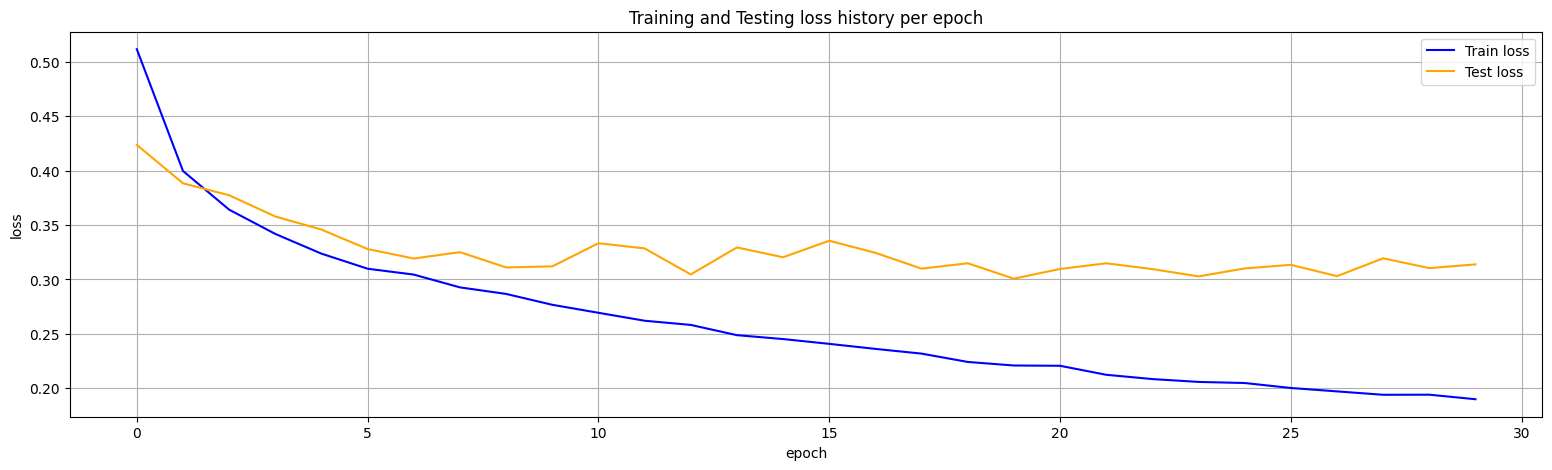

Current Training loss value for the model is = 0.18995624780654907
Current Testing loss value for the model is = 0.31382280588150024
Difference between Current Training and Current Testing loss values for the model is = 0.12386655807495117


In [88]:
#Plotting loss history 

plt.figure(figsize=(19, 5))
plt.title("Training and Testing loss history per epoch")
#plt.xlabel("n-iteration")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_history, 'b', label = "Train loss") 
plt.plot(test_loss_history, 'b', color = 'orange' , label = "Test loss") 
plt.legend(loc = 'best')
plt.grid()
#plt.xticks(range(0, len(loss_history)))

plt.show() 

#****OJO The next message is wrong if the graph was printed PER EPOCH instead of PER ITERATION
#print(f"{len(train_loss_history)} batches were trained each of {len(train_loss_history) // n_epoch} objects during {n_epoch} epochs ")
print(f"Current Training loss value for the model is = {train_loss_history[-1]}")
print(f"Current Testing loss value for the model is = {test_loss_history[-1]}")
print(f"Difference between Current Training and Current Testing loss values for the model is = {test_loss_history[-1] - train_loss_history[-1]}")

C:\Users\gablj\AppData\Local\Temp\ipykernel_56112\1709061117.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(test_accuracy_history, 'b', color = 'orange' , label = "Test accuracy" )


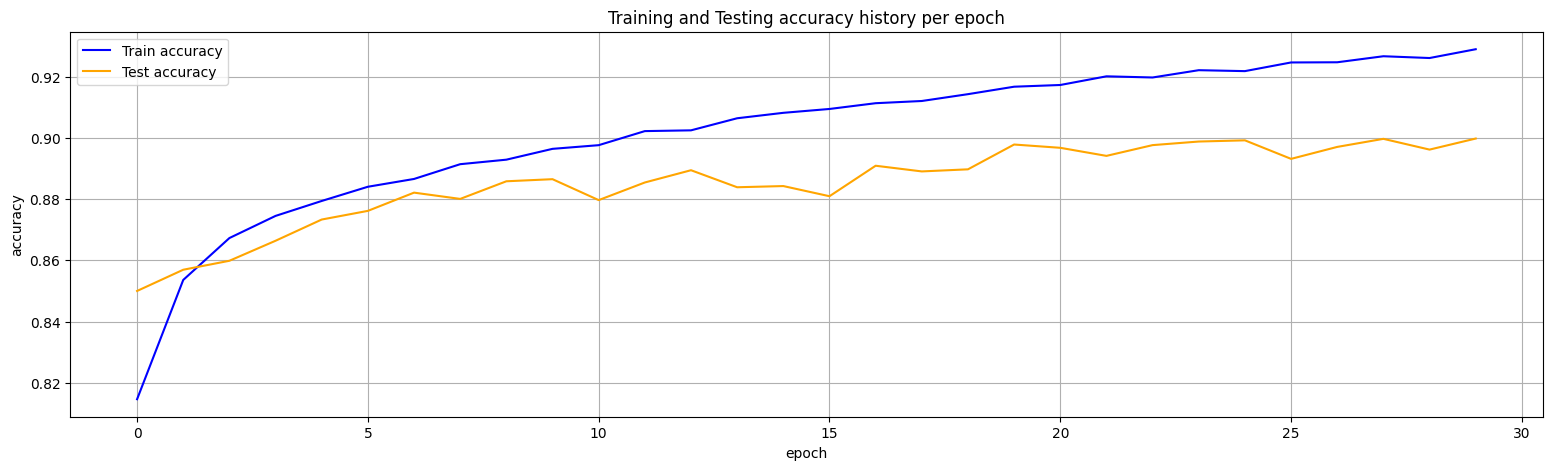

Current Training accuracy score for the model is = 0.9289934257285004
Current Testing accuracy score for the model is = 0.8998046875
Difference between Current Training and Current Testing accuracy score values for the model is = -0.029188738228500433


In [89]:
#Plotting accuracy history 

plt.figure(figsize=(19, 5))
plt.title("Training and Testing accuracy history per epoch")
#plt.xlabel("n-iteration")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy_history, 'b', label = "Train accuracy") 
plt.plot(test_accuracy_history, 'b', color = 'orange' , label = "Test accuracy" ) 
plt.legend(loc = 'best')
plt.grid()
#plt.xticks(range(0, len(loss_history)))

plt.show() 

#****OJO The next message is wrong if the graph was printed PER EPOCH instead of PER ITERATION
#print(f"{len(train_accuracy_history)} batches were trained each of {len(train_accuracy_history) // n_epoch} objects during {n_epoch} epochs ") 
print(f"Current Training accuracy score for the model is = {train_accuracy_history[-1]}")
print(f"Current Testing accuracy score for the model is = {test_accuracy_history[-1]}")
print(f"Difference between Current Training and Current Testing accuracy score values for the model is = {test_accuracy_history[-1] - train_accuracy_history[-1]}")

In [90]:
print(f"The model testing accuracy is = {accuracy(model, test_loader)}")

The model testing accuracy is = 0.8998046875


### Conclusions:
_Write down small report with your conclusions and your ideas._

## For the first part: 

The strategy used was:

-Adding a single hidden layer

-The number of output features (input number of features for the hidden layer) for the input layer was selected as the mean between the input_features size of the input layer, and the output_feature size of the output layer

-Batch normalization was performed before each of the non-linear activation functions

-The activation function used between layers was ReLU 

-The regularization technique used after each activation function was a dropout with p = 0.3 

-The number of epochs choosen was 30 which is 3 multiplied by the number of output_features from the output layer 

-The loss function choosen was Cross Entropy Loss

-and the optimization method used was Adam with a learning rate of 0.01

The previous strategy proved to be useful, since, as can be seen from the plot of loss history, the trainig rate has a favorable shape, and the accuracy history plot shows good accuracy in both training and testing set with little overfitting 

## For the second part:

Two strategies were used:

-First strategy used:

-Two hidden layers were added to the network, the first one had an out_features size of about 64% of the input_features size of the input layer, and the second one had an out_features size of about 38% of the input_feature size of the input layer

-No batch normalization was performed at any point in the network

-The activation function used between layers was ReLU

-No regularization technique used 

-A high number of epochs was used, 90, which is 9 times the out_features size of the out layer, this was done to enforce the network to learn better the training set during the training (that is, so that the network becomes more "familiar" with the training set)

-A subset from the original training set was used, with size of 20% from the total size of the training set used in the first part, this was done so that the network is not familiar with a significant amount of objects from the whole dataset and to enforce it to learn better the reduced training set and therefore to perform better with the training data 

-The loss function choosen was Cross Entropy Loss

-and the optimization method used was Adam with a learning rate of 0.01

The first strategy proved to train a model that overfits the data, this can be seen from both the loss history graph and the accuracy history graph, since in the loss history graph can be seen that, near the end of the training, the loss in the training data is near 0, but the loss in the testing data is closer to 1 than 0, also, in the accuracy history graph can be seen that there's a big gap, specially near the end, in the accuracy of the model, when performing in the training data the accuracy is high, but when performing in the testing data the accuracy is much less than in the training set 



-Second strategy used:

-A single hidden layer was added to the network, with output_features size of 350 features, that is, about 44% from the input_features size of the input layer, in comparision with the first method, the hidden layer is not as loaded as the previous one

-The remaining points stay the same as with the first startegy

The second strategy yield similar results as the first strategy, that is, loss near to 0 for the training set and loss closer to 1 for the testing set, and strong overfitting in the accuracy history plot was traced.

The second strategy was left in this notebook since it returned a slight stronger overfitting than the first strategy 

## For the third part: 

The strategy used was: 

-Adding batch normalization before each of the non-linear activation functions 

-Regularization technique dropout with p = 0.3 used after each activation function

-Number of epochs was decreased from 90 to 30 which is 3 times the number of output_features of the output layer 

-The complete training set was used and not just a part of it

-Same loss function of Cross Entropy Loss was used 

-Same optimization method of Adam with a learning rate of 0.01 was used

This strategy proved to be useful to fix the overfitting, batch normalization and regularization in the form of dropout were used, and also the number of epochs was reduced and the complete training set was used, 
a speed up in the training was noticed, and in the loss history plot can be see that the curve shows a good learning rate, also the loss in the testing set is closer to 0 than 1, and can be seen in the accuracy history plot that the overfitting was significantly reduced